<a href="https://colab.research.google.com/github/WPHdamian/Data-Science-Curriculum-Analysis-/blob/main/03_Curriculum_TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 3 - Topic Modelling of Data Science Curricula

This section applies Latent Dirichlet Allocation (LDA) to module-level curriculum texts
to uncover latent thematic structures in Data Science programmes across Hong Kong and London.

Input:
- Parquet file generated from section 1
- Column used for modelling: `clean_tokens` (bigrams & trigrams)

Outputs:
- All figures saved to `Output/`
- Updated dataframe with topic assignments saved as parquet

Reproducibility:
- Fixed random seed
- Explicit package versions


### 3.2 Environment Setup

This section:
- Loads required libraries
- Fixes random seeds
- Logs package versions for reproducibility


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 65.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import os
import random

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

OUTPUT_DIR = "Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### 3.3 Data Loading

We load the cleaned curriculum dataset produced in Notebook 1.
Only the final processed text field, biagrams and trigrams will be used for topic modelling.


In [4]:
df = pd.read_parquet("curriculum_cleaned.parquet")
df.head()

,city,university,program_name,faculty,level,module_code,module_title,module_description,core_or_elective,module_id,...,is_shared_module,text_combined,clean_text_basic,clean_text_domain,clean_text_syn,entity_tokens,clean_text_entity,clean_tokens,clean_text_final,tokens_final
0,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4301,Corporate Accounting II,This course aims to:\n\ndevelop students' conc...,Elective,cityu_corporate accounting ii_bachelor,...,0,Corporate Accounting II This course aims to: d...,corporate accounting ii course aim develop stu...,corporate accounting ii conceptual professiona...,corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes..."
1,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4342,Auditing,The primary objective of this course is to pro...,Elective,cityu_auditing_bachelor,...,0,Auditing The primary objective of this course ...,audit primary objective course provide student...,audit primary objective regulatory legal repor...,audit primary objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",audit primary_objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",audit primary_objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ..."
2,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2100,Introduction to Financial Accounting,This course aims to:\n\nprovide students with ...,Core,cityu_introduction to financial accounting_bac...,...,0,Introduction to Financial Accounting This cour...,introduction financial accounting course aim p...,financial accounting technical processing prep...,financial accounting technical processing prep...,"[financial_accounting, technical, processing, ...",financial_accounting technical processing prep...,"[financial_accounting, technical, processing, ...",financial_accounting technical processing prep...,"[financial_accounting, technical, processing, ..."
3,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2101,Introduction to Managerial Accounting,This course aims to: 1.provide students with b...,Core,cityu_introduction to managerial accounting_ba...,...,0,Introduction to Managerial Accounting This cou...,introduction managerial accounting course aim ...,managerial accounting management account caree...,managerial accounting management account caree...,"[managerial_accounting, management_account, ca...",managerial_accounting management_account caree...,"[managerial_accounting, management_account, ca...",managerial_accounting management_account caree...,"[managerial_accounting, management_account, ca..."
4,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2200,Business Statistics,This course aims to facilitate students' learn...,Core,cityu_business statistics_bachelor,...,0,Business Statistics This course aims to facili...,business statistic course aim facilitate stude...,business statistic facilitate statistical comm...,business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,..."


### 3.4 Selecting Number of Topics (K)

LDA performance depends on the choice of topic number K.

We evaluate models across a range of K values using coherence scores
(c_v metric), which captures semantic interpretability.

This step is performed:
- Overall
- Separately for each city (London, Hong Kong)


In [5]:
dictionary = corpora.Dictionary(df["clean_tokens"])

dictionary.filter_extremes(
    no_below=5,     # appears in at least 5 modules
    no_above=0.8    # appears in at most 80% of modules
)

corpus = [dictionary.doc2bow(tokens) for tokens in df["clean_tokens"]]

len(dictionary)


2523

#### 3.4.1 Coherence Function

In [6]:
def compute_coherence_values(dictionary, corpus, texts, k_range):
    coherence_scores = []

    for k in k_range:
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=SEED,
            passes=50,
            alpha="symmetric",
            eta=0.1
        )

        coherence_model = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        )

        coherence_scores.append(coherence_model.get_coherence())

    return coherence_scores



#### 3.4.2 Plot Coherence vs K (Overall)

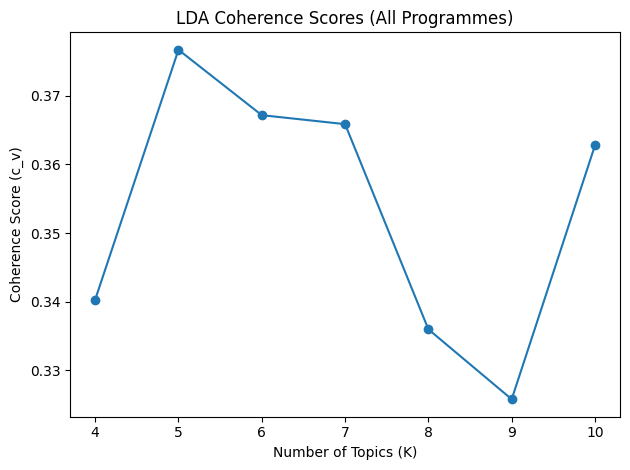

In [7]:
k_range = range(4, 11)
coherence_scores = compute_coherence_values(
    dictionary, corpus, df["clean_tokens"], k_range
)

plt.figure()
plt.plot(k_range, coherence_scores, marker="o")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Coherence Scores (All Programmes)")
plt.tight_layout()
plt.savefig("Output/lda_coherence_curve.png", dpi=300, bbox_inches="tight")
plt.show()


The best k is found to be 5, with cv_score of 0.3766738891446237

In [11]:
optimal_k = 5
print(f"Optimal K is: {optimal_k}, with a cv_score of {max(coherence_scores)}")

Optimal K is: 5, with a cv_score of 0.3766738891446237


#### 3.4.3 Final Topic Model

Based on coherence analysis, we select the optimal K
and estimate the final LDA model for interpretation.


In [12]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_k,
    passes=50,
    alpha='symmetric',
    eta=0.1,
    random_state=SEED
)


#### Topic term distributions

In [13]:
def show_topics(model, num_words=12):
    topics = model.show_topics(num_topics=6, num_words=num_words, formatted=False)
    for topic_num, words in topics:
        terms = [w for w, _ in words]
        print(f"\nTOPIC {topic_num+1}")
        print("Keywords:", " | ".join(terms))

show_topics(lda_model)


TOPIC 1
Keywords: business | management | system | technique | problem | design | process | application | technology | analytic | analysis | tool

TOPIC 2
Keywords: data | algorithm | model | application | fundamental | programming | technique | data_structure | design | computer | system | analysis

TOPIC 3
Keywords: economic | research | design | social | theory | data | analysis | health | policy | change | development | explore

TOPIC 4
Keywords: data | model | machine | statistical | application | technique | analysis | data_analytic | tool | deep | advanced | problem

TOPIC 5
Keywords: policy | economic | network | issue | security | application | discuss | system | public_policy | social | political | technology


- **Topic 1: Business Systems and Analytics**
- **Topic 2: Technical Fundamentals and Programming**
- **Topic 3: Social and Economic Research**
- **Topic 4: Data Analytics and Machine Learning**
- **Topic 5: Public Policy, Technology, and Security**

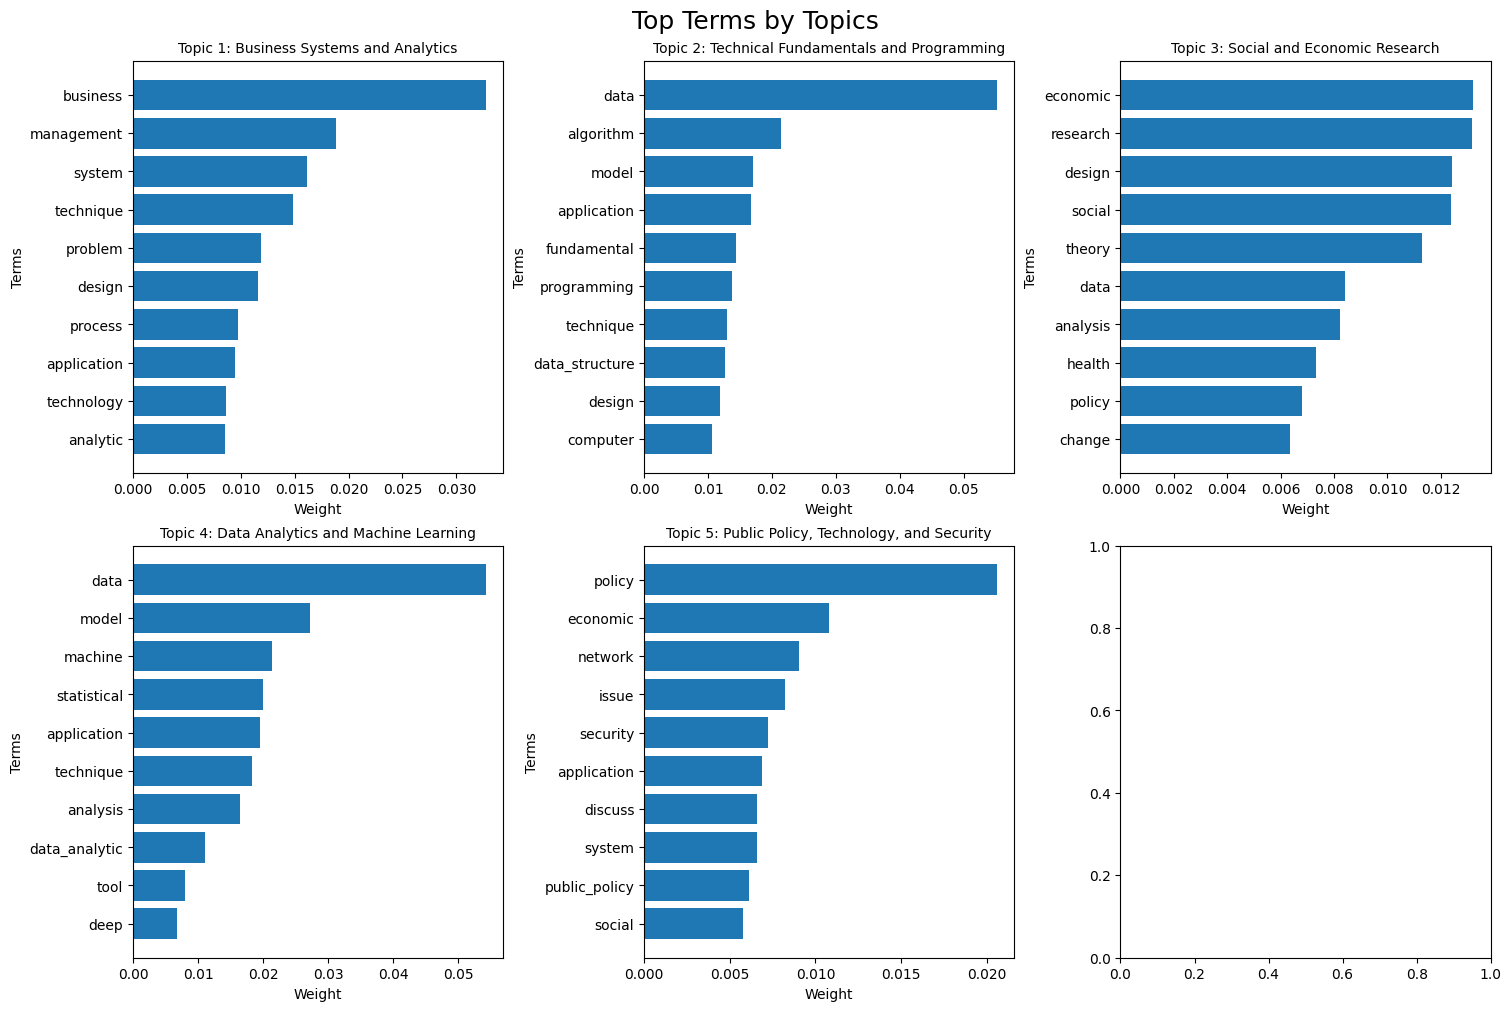

In [23]:
# Define the topic labels
topic_labels = [
    "Business Systems and Analytics",
    "Technical Fundamentals and Programming",
    "Social and Economic Research",
    "Data Analytics and Machine Learning",
    "Public Policy, Technology, and Security"
]

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

# Loop through each topic and plot on the corresponding subplot
for topic_id in range(optimal_k):
    terms = lda_model.show_topic(topic_id, topn=10)
    words, weights = zip(*terms)

    # Select the corresponding subplot
    ax = axes[topic_id // 3, topic_id % 3]
    ax.barh(words, weights)
    ax.invert_yaxis()
    ax.set_title(f"Topic {topic_id+1}: {topic_labels[topic_id]}", fontsize=10)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Terms")

# Adjust spacing and save the figure
fig.suptitle("Top Terms by Topics", fontsize=18)
plt.savefig("Output/topics_subplots.png", dpi=300, bbox_inches="tight")
plt.show()

### 3.5 Topic Assignment at Module Level
#### 3.5.1 Dominant Topic per Module


In [15]:
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

dominant_topics = []
topic_probs = []

for dist in topic_distributions:
    if dist:
        top_topic = max(dist, key=lambda x: x[1])
        dominant_topics.append(top_topic[0] + 1)  # +1 for readability
        topic_probs.append(top_topic[1])
    else:
        dominant_topics.append(None)
        topic_probs.append(None)

df["dominant_topic"] = dominant_topics
df["topic_probability"] = topic_probs

df[["module_title", "dominant_topic", "topic_probability"]].head()

,module_title,dominant_topic,topic_probability
0,Corporate Accounting II,4,0.318844
1,Auditing,1,0.971788
2,Introduction to Financial Accounting,4,0.635526
3,Introduction to Managerial Accounting,1,0.977423
4,Business Statistics,4,0.723241


## **3.6 Comparative Analysis: City-Level Topic Profiles**

Purpose:
- Test whether the distribution of dominant topics differs between **Hong Kong** and **London**.

#### 3.6.1 Topic Distribution by City (Descriptive Overview)

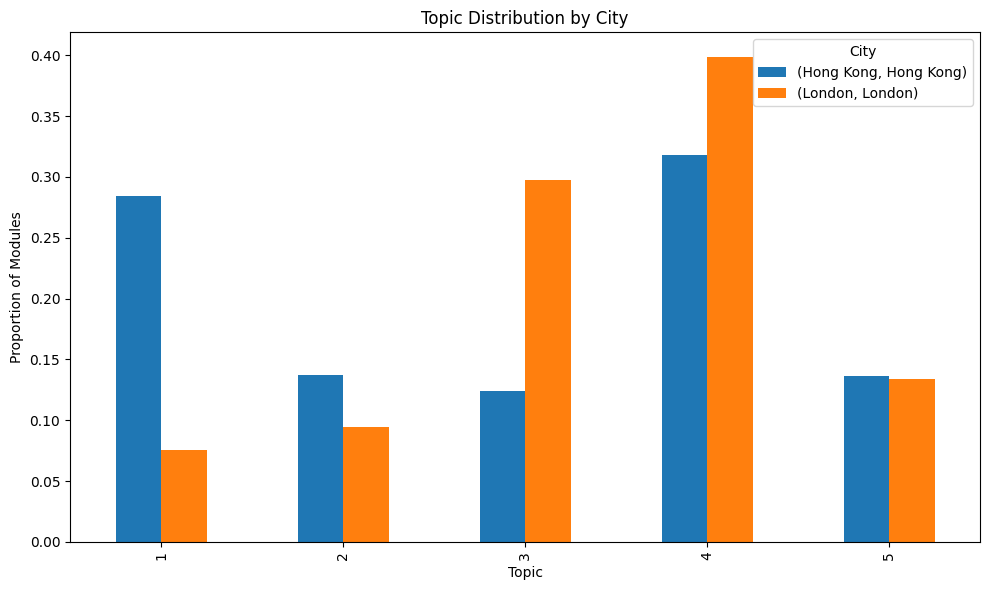

In [16]:
topic_city_dist = (
    df.groupby(["city", "dominant_topic"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

topic_city_dist.T.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Topic")
plt.ylabel("Proportion of Modules")
plt.title("Topic Distribution by City")
plt.legend(title="City")
plt.tight_layout()
plt.show()


#### 3.6.2a Chi-Square Test of Independence (City × Topic)

Next, we test whether curriculum topic distributions differ systematically between London and Hong Kong.

In [17]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df["city"], df["dominant_topic"])
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.3f}")
print(f"p-value: {p:.4f}")


Chi-square statistic: 162.986
p-value: 0.0000


#### 3.6.2b Effect Size: Cramér’s V

In [18]:
import numpy as np

n = contingency.values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

print(f"Cramér’s V: {cramers_v:.3f}")


Cramér’s V: 0.321


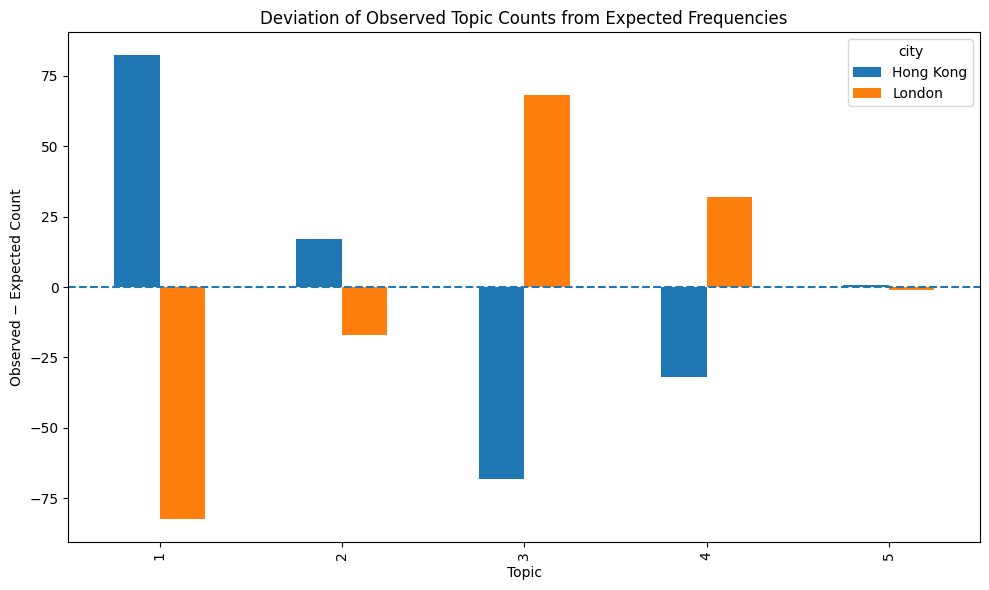

In [19]:
expected_df = pd.DataFrame(
    expected,
    index=contingency.index,
    columns=contingency.columns
)

(contingency - expected_df).T.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.axhline(0, linestyle="--")
plt.xlabel("Topic")
plt.ylabel("Observed − Expected Count")
plt.title("Deviation of Observed Topic Counts from Expected Frequencies")
plt.tight_layout()
plt.show()


#### 3.6.3 Jensen–Shannon Divergence (Overall Curriculum Orientation)

We quantify the overall divergence between curriculum topic profiles across cities.

In [20]:
from scipy.spatial.distance import jensenshannon
import numpy as np

p_london = topic_city_dist.loc["London"].values
p_hk = topic_city_dist.loc["Hong Kong"].values

p_london = np.asarray(p_london).flatten()
p_hk = np.asarray(p_hk).flatten()

js_divergence = jensenshannon(p_london, p_hk)

print(f"Jensen–Shannon Divergence: {js_divergence:.4f}")


Jensen–Shannon Divergence: 0.2346


#### 3.6.4 Curriculum Breadth: Topic Entropy

We compare curriculum breadth versus specialisation between cities.

In [21]:
from scipy.stats import entropy

entropy_london = entropy(p_london)
entropy_hk = entropy(p_hk)

print(f"Topic Entropy (London): {entropy_london:.3f}")
print(f"Topic Entropy (Hong Kong): {entropy_hk:.3f}")

Topic Entropy (London): 1.414
Topic Entropy (Hong Kong): 1.525


#### 3.6.5 Structural Emphasis: Core vs Elective Distribution

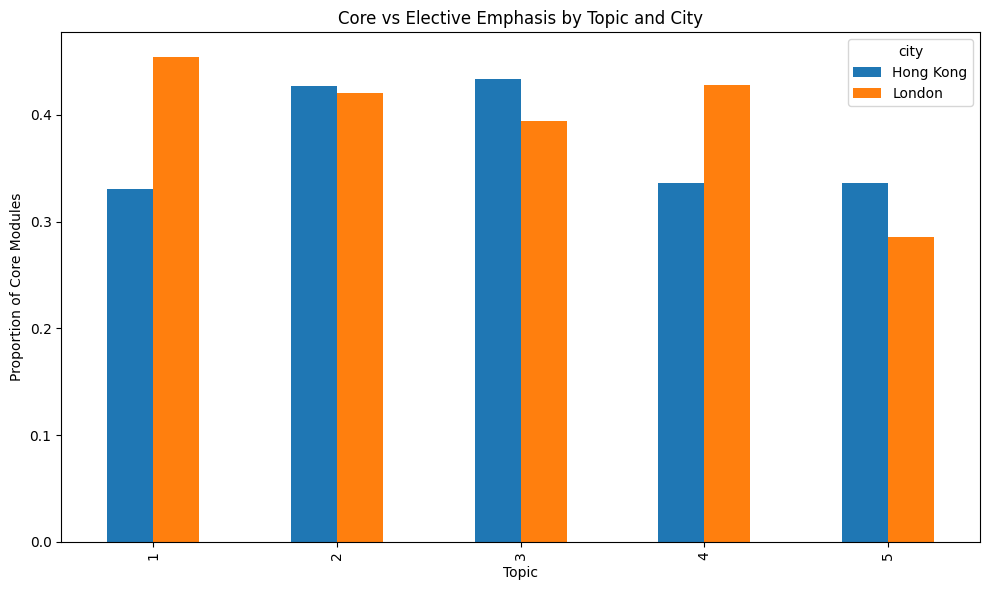

In [22]:
df["is_core"] = (df["core_or_elective"] == "Core").astype(int)

core_dist = (
    df.groupby(["city", "dominant_topic"])["is_core"]
      .mean()
      .unstack(fill_value=0)
)

core_dist.T.plot(
    kind="bar",
    figsize=(10, 6)
)

df = df.drop(columns="is_core")

plt.xlabel("Topic")
plt.ylabel("Proportion of Core Modules")
plt.title("Core vs Elective Emphasis by Topic and City")
plt.tight_layout()
plt.show()


### 3.7 Summary

This notebook identified latent curricular themes in Data Science programmes
using LDA topic modelling. Topics were selected via coherence optimisation and
assigned at the module level.

Outputs from this notebook:
- Topic-term visualisations
- City-level topic distributions
- Module-level topic labels (saved in parquet)

These results form the basis for:
- Curriculum orientation analysis (RQ1)
- Mapping topics to EDISON competence domains (Notebook 3)
- Curriculum–labour market alignment (RQ2)


In [24]:
df.to_parquet("curriculum_with_topics.parquet", index=False)